In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
batch_size = 128
image_size = 28
channels = 1
time_steps = 1000  # Default, will be varied in part (b)
learning_rate = 2e-4
num_epochs = 3

# Data Loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# U-Net modules
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.time_emb_proj = nn.Linear(256, out_channels)
        
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.shortcut = nn.Identity()
    
    def forward(self, x, time_emb=None):
        identity = self.shortcut(x)
        
        x = F.relu(self.conv1(x))
        if time_emb is not None:
            time_emb = self.time_emb_proj(time_emb)[:, :, None, None]
            x = x + time_emb
        x = F.relu(self.conv2(x))
        
        return x + identity

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels)
        self.down = nn.Conv2d(out_channels, out_channels, 4, stride=2, padding=1)
    
    def forward(self, x, time_emb):
        x = self.res(x, time_emb)
        return self.down(x)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.res = ResidualBlock(out_channels * 2, out_channels)  # Ensure correct channel size

    def forward(self, x, skip, time_emb):
        x = self.up(x)
        if x.shape[-2:] != skip.shape[-2:]:  
            x = F.interpolate(x, size=skip.shape[2:])  
        x = torch.cat([x, skip], dim=1)  
        return self.res(x, time_emb)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        half_dim = self.dim // 2
        embeddings = torch.log(torch.tensor(10000.0, device=time.device)) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=time.device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((torch.sin(embeddings), torch.cos(embeddings)), dim=-1)
        return embeddings.to(time.device)

# UNet model for DDPM - Replacing Attention with Additional Conv layers
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        
        # Time embeddings
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(128),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
        )
        
        # Initial conv
        self.init_conv = nn.Conv2d(in_channels, 64, 3, padding=1)
        
        # Encoder
        self.down1 = DownBlock(64, 128)
        self.down2 = DownBlock(128, 256)
        
        # Bottleneck with extra conv layers
        self.bottleneck = nn.Sequential(
            ResidualBlock(256, 256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # Decoder (fixed incorrect input channel mismatch)
        self.up1 = UpBlock(256, 128)
        self.up2 = UpBlock(128, 64)  # Ensure correct input channels

        # Final conv
        self.final_conv = nn.Conv2d(64, out_channels, 1)
    
    def forward(self, x, time):
        time_emb = self.time_mlp(time).to(x.device)
        
        # Encoder
        x1 = self.init_conv(x)
        x2 = self.down1(x1, time_emb)
        x3 = self.down2(x2, time_emb)
        
        # Bottleneck
        x3 = self.bottleneck(x3)
        
        # Decoder (fixed channel flow)
        x = self.up1(x3, x2, time_emb)
        x = self.up2(x, x1, time_emb)
        
        return self.final_conv(x)

# Training function

def train_ddpm(model, dataloader, optimizer, epochs, device):
    model.to(device)
    losses = []
    
    for epoch in range(epochs):
        total_loss = 0
        num_batches = len(dataloader)
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        
        for batch in progress_bar:
            optimizer.zero_grad()
            
            x, _ = batch
            x = x.to(device)
            
            t = torch.randint(0, time_steps, (x.shape[0],), device=device).long()
            noise = torch.randn_like(x)
            
            predicted_noise = model(x, t)
            
            loss = F.mse_loss(noise, predicted_noise)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            progress_bar.set_postfix({"loss": loss.item()})
        
        avg_loss = total_loss / num_batches
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.6f}")
    
    return losses
    
model = UNet()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = train_ddpm(model, train_loader, optimizer, num_epochs, device)

Using device: cuda


Epoch 1/3: 100%|██████████| 469/469 [01:13<00:00,  6.37it/s, loss=0.992]


Epoch 1/3, Average Loss: 1.000364


Epoch 2/3: 100%|██████████| 469/469 [01:19<00:00,  5.87it/s, loss=0.994]


Epoch 2/3, Average Loss: 1.000208


Epoch 3/3: 100%|██████████| 469/469 [01:19<00:00,  5.92it/s, loss=0.995]

Epoch 3/3, Average Loss: 1.000369


Using device: cuda


100%|██████████| 469/469 [01:14<00:00,  6.27it/s]


Epoch 1/20, Loss: 0.03756164759397507


100%|██████████| 469/469 [01:14<00:00,  6.32it/s]


Epoch 2/20, Loss: 0.029691481962800026


100%|██████████| 469/469 [01:14<00:00,  6.27it/s]


Epoch 3/20, Loss: 0.03606612607836723


100%|██████████| 469/469 [01:15<00:00,  6.25it/s]


Epoch 4/20, Loss: 0.028872106224298477


100%|██████████| 469/469 [01:14<00:00,  6.27it/s]


Epoch 5/20, Loss: 0.016741110011935234


100%|██████████| 469/469 [01:15<00:00,  6.22it/s]


Epoch 6/20, Loss: 0.03438519686460495


100%|██████████| 469/469 [01:14<00:00,  6.32it/s]


Epoch 7/20, Loss: 0.030374545603990555


100%|██████████| 469/469 [01:14<00:00,  6.28it/s]


Epoch 8/20, Loss: 0.023937152698636055


100%|██████████| 469/469 [01:15<00:00,  6.24it/s]


Epoch 9/20, Loss: 0.029721589758992195


100%|██████████| 469/469 [01:15<00:00,  6.23it/s]


Epoch 10/20, Loss: 0.022937793284654617


100%|██████████| 469/469 [01:15<00:00,  6.22it/s]


Epoch 11/20, Loss: 0.02502160705626011


100%|██████████| 469/469 [01:15<00:00,  6.23it/s]


Epoch 12/20, Loss: 0.02616257593035698


100%|██████████| 469/469 [01:15<00:00,  6.23it/s]


Epoch 13/20, Loss: 0.021635346114635468


100%|██████████| 469/469 [01:15<00:00,  6.24it/s]


Epoch 14/20, Loss: 0.02276395820081234


100%|██████████| 469/469 [01:15<00:00,  6.23it/s]


Epoch 15/20, Loss: 0.030754737555980682


100%|██████████| 469/469 [01:15<00:00,  6.25it/s]


Epoch 16/20, Loss: 0.022278103977441788


100%|██████████| 469/469 [01:14<00:00,  6.25it/s]


Epoch 17/20, Loss: 0.024949491024017334


100%|██████████| 469/469 [01:14<00:00,  6.26it/s]


Epoch 18/20, Loss: 0.0262086633592844


100%|██████████| 469/469 [01:14<00:00,  6.26it/s]


Epoch 19/20, Loss: 0.033470142632722855


100%|██████████| 469/469 [01:14<00:00,  6.26it/s]


Epoch 20/20, Loss: 0.02568204700946808


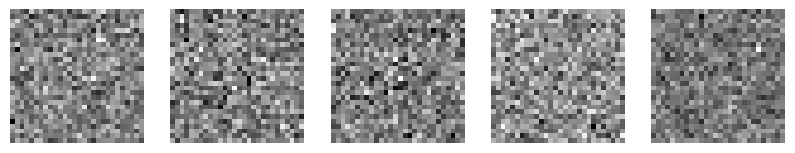

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
batch_size = 128
image_size = 28
channels = 1
time_steps = 1000  # Default, will be varied in part (b)
learning_rate = 2e-4
num_epochs = 20

# Data Loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Noise schedule
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, time_steps).to(device)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

def forward_diffusion(x_0, t, device=device):
    noise = torch.randn_like(x_0)
    sqrt_alpha_bar_t = torch.sqrt(alpha_bars[t])[:, None, None, None]
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bars[t])[:, None, None, None]
    return sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise, noise

# Well-structured U-Net model
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.time_emb_proj = nn.Linear(256, out_channels)
        
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.shortcut = nn.Identity()
    
    def forward(self, x, time_emb=None):
        identity = self.shortcut(x)
        
        x = F.relu(self.conv1(x))
        if time_emb is not None:
            time_emb = self.time_emb_proj(time_emb)[:, :, None, None]
            x = x + time_emb
        x = F.relu(self.conv2(x))
        
        return x + identity

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels)
        self.down = nn.Conv2d(out_channels, out_channels, 4, stride=2, padding=1)
    
    def forward(self, x, time_emb):
        x = self.res(x, time_emb)
        return self.down(x)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.res = ResidualBlock(out_channels * 2, out_channels)

    def forward(self, x, skip, time_emb):
        x = self.up(x)
        if x.shape[-2:] != skip.shape[-2:]:  
            x = F.interpolate(x, size=skip.shape[2:])  
        x = torch.cat([x, skip], dim=1)  
        return self.res(x, time_emb)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        half_dim = self.dim // 2
        embeddings = torch.log(torch.tensor(10000.0, device=time.device)) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=time.device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((torch.sin(embeddings), torch.cos(embeddings)), dim=-1)
        return embeddings.to(time.device)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(128),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
        )
        
        self.init_conv = nn.Conv2d(in_channels, 64, 3, padding=1)
        
        self.down1 = DownBlock(64, 128)
        self.down2 = DownBlock(128, 256)
        
        self.bottleneck = nn.Sequential(
            ResidualBlock(256, 256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.up1 = UpBlock(256, 128)
        self.up2 = UpBlock(128, 64)
        
        self.final_conv = nn.Conv2d(64, out_channels, 1)
    
    def forward(self, x, time):
        time_emb = self.time_mlp(time).to(x.device)
        
        x1 = self.init_conv(x)
        x2 = self.down1(x1, time_emb)
        x3 = self.down2(x2, time_emb)
        
        x3 = self.bottleneck(x3)
        
        x = self.up1(x3, x2, time_emb)
        x = self.up2(x, x1, time_emb)
        
        return self.final_conv(x)

# Training function
def train_model(model, optimizer, epochs):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        for images, _ in tqdm(train_loader):
            images = images.to(device)
            t = torch.randint(0, time_steps, (images.shape[0],), device=device).long()
            noisy_images, noise = forward_diffusion(images, t)
            optimizer.zero_grad()
            predicted_noise = model(noisy_images, t)
            loss = F.mse_loss(predicted_noise, noise)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Visualization
def visualize_samples(model, num_images=5):
    model.eval()
    with torch.no_grad():
        noise = torch.randn((num_images, 1, image_size, image_size), device=device)
        t = torch.full((num_images,), time_steps - 1, device=device, dtype=torch.long)
        generated_images = model(noise, t)
        
        fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
        for i in range(num_images):
            axes[i].imshow(generated_images[i].cpu().squeeze(), cmap="gray")
            axes[i].axis("off")
        plt.show()

# Training and visualization
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, optimizer, num_epochs)
visualize_samples(model)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
batch_size = 128
image_size = 28
channels = 1
time_steps = 1000  # Default, will be varied in part (b)
learning_rate = 2e-4
num_epochs = 10

# Data Loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Noise schedule
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, time_steps).to(device)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

def forward_diffusion(x_0, t, device=device):
    noise = torch.randn_like(x_0)
    sqrt_alpha_bar_t = torch.sqrt(alpha_bars[t])[:, None, None, None]
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bars[t])[:, None, None, None]
    return sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise, noise

# Attention Block
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        batch, C, H, W = x.shape
        query = self.query(x).view(batch, -1, H * W).permute(0, 2, 1)
        key = self.key(x).view(batch, -1, H * W)
        value = self.value(x).view(batch, C, -1)
        
        attention = torch.softmax(torch.bmm(query, key) / (C ** 0.5), dim=-1)
        out = torch.bmm(value, attention.permute(0, 2, 1)).view(batch, C, H, W)
        return self.gamma * out + x

# Sinusoidal Time Embedding
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=t.device) * 
                        (-torch.log(torch.tensor(10000.0)) / (half_dim - 1)))
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=-1)
        return emb

# Well-structured U-Net model with Attention
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim=256):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.attn = SelfAttention(out_channels)
        self.time_emb_proj = nn.Linear(time_emb_dim, out_channels) if time_emb_dim else None
        
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.shortcut = nn.Identity()
    
    def forward(self, x, time_emb=None):
        identity = self.shortcut(x)
        x = F.relu(self.conv1(x))
        if time_emb is not None and self.time_emb_proj is not None:
            time_emb = self.time_emb_proj(time_emb)[:, :, None, None]
            x = x + time_emb
        x = F.relu(self.conv2(x))
        x = self.attn(x)
        return x + identity

# Define U-Net Model with Attention
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, time_emb_dim=256):
        super().__init__()
        self.time_embedding = SinusoidalTimeEmbedding(time_emb_dim)
        self.init_conv = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.down1 = ResidualBlock(64, 128, time_emb_dim)
        self.down2 = ResidualBlock(128, 256, time_emb_dim)
        
        self.bottleneck = nn.Sequential(
            ResidualBlock(256, 256, time_emb_dim),
            SelfAttention(256)
        )
        
        self.up1 = ResidualBlock(256, 128, time_emb_dim)
        self.up2 = ResidualBlock(128, 64, time_emb_dim)
        
        self.final_conv = nn.Conv2d(64, out_channels, 1)
    
    def forward(self, x, time):
        time_emb = self.time_embedding(time)
        x1 = self.init_conv(x)
        x2 = self.down1(x1, time_emb)
        x3 = self.down2(x2, time_emb)
        x3 = self.bottleneck(x3)
        x = self.up1(x3, time_emb)
        x = self.up2(x, time_emb)
        return self.final_conv(x)

# Training and visualization
def train_model(model, optimizer, epochs):
    model.to(device)
    for epoch in range(epochs):
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            x, _ = batch
            x = x.to(device)
            t = torch.randint(0, time_steps, (x.shape[0],), device=device).long()
            noisy_x, noise = forward_diffusion(x, t)
            predicted_noise = model(noisy_x, t)
            loss = F.mse_loss(noise, predicted_noise)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

def visualize_samples(model):
    model.eval()
    with torch.no_grad():
        noise = torch.randn((16, 1, 28, 28), device=device)
        samples = model(noise, torch.zeros(16, device=device).long())
        samples = samples.cpu().numpy().squeeze()
        fig, axes = plt.subplots(4, 4, figsize=(5, 5))
        for i, ax in enumerate(axes.flat):
            ax.imshow(samples[i], cmap='gray')
            ax.axis('off')
        plt.show()

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, optimizer, num_epochs)
visualize_samples(model)


Using device: cuda
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 343kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.21MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 469/469 [06:24<00:00,  1.22it/s]


Epoch 1/10, Loss: 0.027947


100%|██████████| 469/469 [06:36<00:00,  1.18it/s]


Epoch 2/10, Loss: 0.026234


100%|██████████| 469/469 [06:35<00:00,  1.19it/s]


Epoch 3/10, Loss: 0.031161


100%|██████████| 469/469 [06:35<00:00,  1.19it/s]


Epoch 4/10, Loss: 0.025953


 76%|███████▌  | 357/469 [05:01<01:34,  1.18it/s]

Epoch 5/10, Loss: 0.015562


100%|██████████| 469/469 [06:37<00:00,  1.18it/s]


Epoch 6/10, Loss: 0.033744


100%|██████████| 469/469 [06:37<00:00,  1.18it/s]


Epoch 7/10, Loss: 0.029896


100%|██████████| 469/469 [06:37<00:00,  1.18it/s]


Epoch 8/10, Loss: 0.025171


100%|██████████| 469/469 [06:36<00:00,  1.18it/s]


Epoch 9/10, Loss: 0.027680


100%|██████████| 469/469 [06:36<00:00,  1.18it/s]


Epoch 10/10, Loss: 0.025365


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 43.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.16MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.4MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 13.0MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch 1, Loss: 0.0370
Epoch 2, Loss: 0.0214
Epoch 3, Loss: 0.0251
Epoch 4, Loss: 0.0163
Epoch 5, Loss: 0.0149
Sampling with 50 timesteps


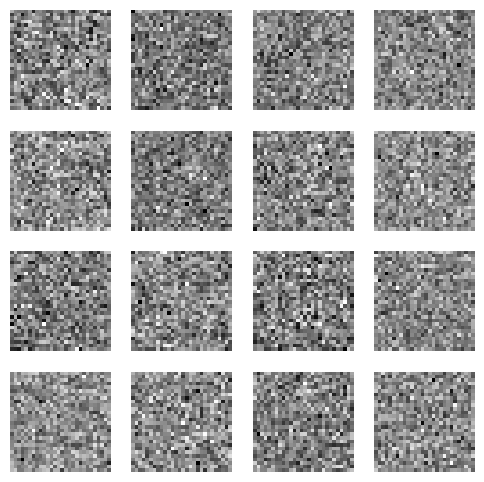

Sampling with 100 timesteps


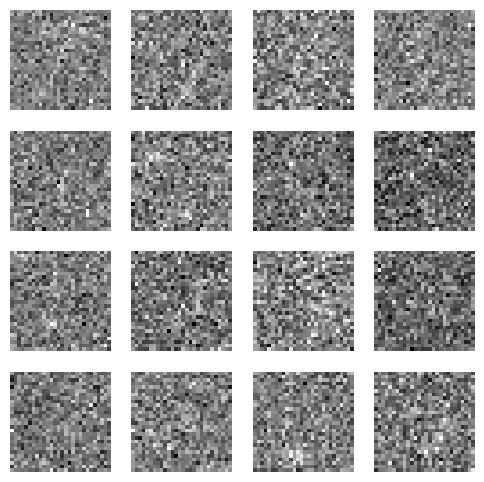

Sampling with 500 timesteps


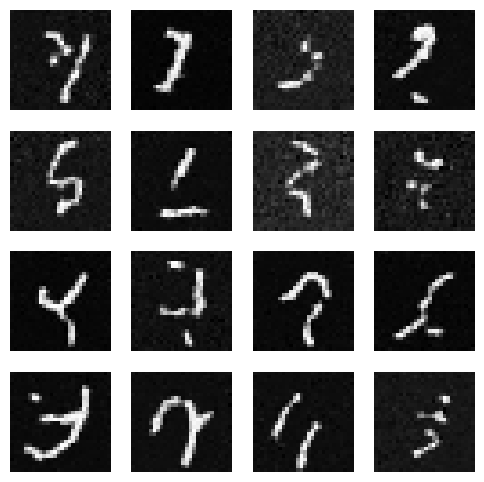

Sampling with 1000 timesteps


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 16.12 MiB is free. Process 2335 has 14.72 GiB memory in use. Of the allocated memory 14.42 GiB is allocated by PyTorch, and 188.85 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Define a U-Net with residual skip connections and explicit Up/Down blocks
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()
    
    def forward(self, x):
        residual = self.skip(x)
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        return self.relu(x + residual)

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.residual = ResidualBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        x = self.residual(x)
        return self.pool(x), x

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.residual = ResidualBlock(out_channels * 2, out_channels)
    
    def forward(self, x, skip_connection):
        x = self.upsample(x)
        x = torch.cat([x, skip_connection], dim=1)
        return self.residual(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = DownBlock(1, 32)
        self.down2 = DownBlock(32, 64)
        self.middle = ResidualBlock(64, 128)
        self.up1 = UpBlock(128, 64)
        self.up2 = UpBlock(64, 32)
        self.final_conv = nn.Conv2d(32, 1, kernel_size=1)
    
    def forward(self, x, t):
        x1, skip1 = self.down1(x)
        x2, skip2 = self.down2(x1)
        x = self.middle(x2)
        x = self.up1(x, skip2)
        x = self.up2(x, skip1)
        return self.final_conv(x)

# Define the diffusion process
class DDPM:
    def __init__(self, model, timesteps=1000):
        self.model = model.cuda()
        self.timesteps = timesteps
        self.betas = torch.linspace(0.0001, 0.02, timesteps).cuda()
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)
    
    def forward_diffusion(self, x0, t):
        noise = torch.randn_like(x0).cuda()
        mean = self.alpha_bar[t].sqrt().view(-1, 1, 1, 1) * x0
        std = (1 - self.alpha_bar[t]).sqrt().view(-1, 1, 1, 1)
        return mean + std * noise, noise
    
    def sample(self, num_samples=16, timesteps=None):
        if timesteps is None:
            timesteps = self.timesteps
        x = torch.randn((num_samples, 1, 28, 28)).cuda()
        for t in reversed(range(timesteps)):
            z = torch.randn_like(x) if t > 0 else 0
            t_tensor = torch.full((num_samples,), t, device="cuda", dtype=torch.long)
            pred_noise = self.model(x, t_tensor)
            x = (x - self.betas[t] / (1 - self.alpha_bar[t]).sqrt() * pred_noise) / self.alphas[t].sqrt() + z * self.betas[t].sqrt()
        return x.cpu().detach()

# Load MNIST dataset
dataset = datasets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Training loop
def train(model, diffusion, epochs=5, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    
    for epoch in range(epochs):
        for x0, _ in dataloader:
            x0 = x0.cuda()
            t = torch.randint(0, diffusion.timesteps, (x0.size(0),), device="cuda")
            noisy_x, noise = diffusion.forward_diffusion(x0, t)
            pred_noise = model(noisy_x, t)
            loss = loss_fn(pred_noise, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Run training
model = UNet()
diffusion = DDPM(model, timesteps=1000)
train(model, diffusion, epochs=5)

# Experiment with different timesteps
def compare_timesteps():
    for steps in [50, 100, 500, 1000]:
        print(f"Sampling with {steps} timesteps")
        samples = diffusion.sample(num_samples=16, timesteps=steps)
        fig, axes = plt.subplots(4, 4, figsize=(6, 6))
        for i, ax in enumerate(axes.flatten()):
            ax.imshow(samples[i, 0], cmap='gray')
            ax.axis('off')
        plt.show()
compare_timesteps()

# Visualize generative process
def visualize_process():
    x = torch.randn((1, 1, 28, 28)).cuda()
    steps = [0, 250, 500, 750, 999]
    fig, axes = plt.subplots(1, len(steps), figsize=(15, 3))
    for i, t in enumerate(steps):
        x = diffusion.sample(num_samples=1, timesteps=t)
        axes[i].imshow(x[0, 0], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"t={t}")
    plt.show()
visualize_process()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

# Load MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Define U-Net Model with Residual Skip Connections
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.relu = nn.ReLU()
        self.residual = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        residual = self.residual(x)
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        return self.relu(x + residual)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            ResidualBlock(1, 64),
            nn.MaxPool2d(2),
            ResidualBlock(64, 128),
            nn.MaxPool2d(2)
        )
        self.middle = ResidualBlock(128, 128)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            ResidualBlock(64, 64),
            nn.ConvTranspose2d(64, 1, 2, stride=2),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x

# Define Diffusion Model with Improved Noise Scheduling
class DDPM(nn.Module):
    def __init__(self, unet, timesteps=10000):
        super().__init__()
        self.unet = unet
        self.timesteps = timesteps
        self.betas = torch.linspace(0.0001, 0.02, timesteps)  # Linear schedule
        self.alphas = 1.0 - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)
        
        # Improved noise schedule (cosine schedule)
        self.cosine_schedule = torch.cos(torch.linspace(0, np.pi / 2, timesteps)) ** 2
        self.betas = 1 - (self.cosine_schedule[1:] / self.cosine_schedule[:-1])
        self.betas = torch.cat([self.betas, self.betas[-1].unsqueeze(0)])
        self.alphas = 1.0 - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)
    
    def forward(self, x, t):
        noise = torch.randn_like(x)
        alpha_t = self.alpha_hat[t].view(-1, 1, 1, 1)
        return torch.sqrt(alpha_t) * x + torch.sqrt(1 - alpha_t) * noise

# Training Loop
ddpm = DDPM(UNet()).to("cuda")
optimizer = optim.Adam(ddpm.unet.parameters(), lr=1e-4)

for epoch in range(10):
    for images, _ in dataloader:
        images = images.to("cuda")
        t = torch.randint(0, 1000, (images.shape[0],), device="cuda")
        noisy_images = ddpm(images, t)
        predicted_noise = ddpm.unet(noisy_images)
        loss = nn.MSELoss()(predicted_noise, torch.randn_like(images))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}: Loss {loss.item()}")

# Visualization: Sampling from the trained model
def sample_images(model, timesteps=1000):
    model.eval()
    with torch.no_grad():
        x = torch.randn(16, 1, 28, 28, device="cuda")
        for t in reversed(range(timesteps)):
            t_tensor = torch.full((16,), t, device="cuda", dtype=torch.long)
            noise_pred = model.unet(x)
            alpha_t = model.alpha_hat[t].view(-1, 1, 1, 1)
            x = (x - torch.sqrt(1 - alpha_t) * noise_pred) / torch.sqrt(alpha_t)
    return x.cpu()

samples = sample_images(ddpm)
fig, axes = plt.subplots(4, 4, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i, 0].numpy(), cmap="gray")
    ax.axis("off")
plt.show()


Epoch 1/20: 100%|██████████| 938/938 [00:45<00:00, 20.66it/s]


Epoch 1/20, Loss: 0.046396


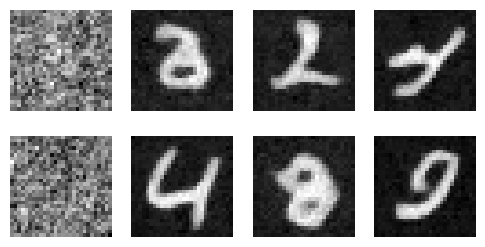

Epoch 2/20: 100%|██████████| 938/938 [00:46<00:00, 20.21it/s]


Epoch 2/20, Loss: 0.046958


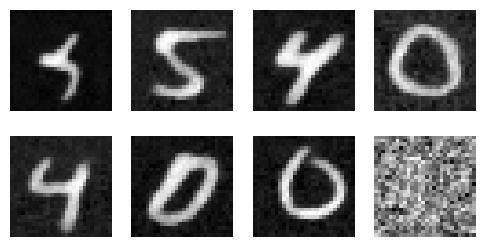

Epoch 3/20: 100%|██████████| 938/938 [00:46<00:00, 20.00it/s]


Epoch 3/20, Loss: 0.036506


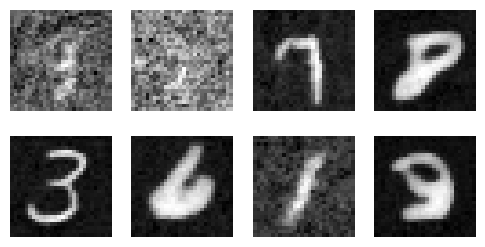

Epoch 4/20: 100%|██████████| 938/938 [00:47<00:00, 19.88it/s]


Epoch 4/20, Loss: 0.042936


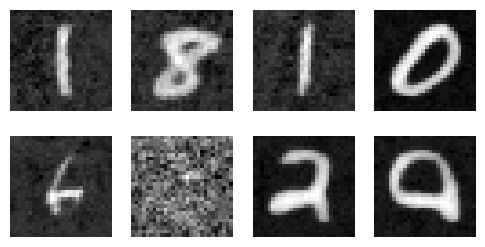

Epoch 5/20: 100%|██████████| 938/938 [00:47<00:00, 19.78it/s]


Epoch 5/20, Loss: 0.033985


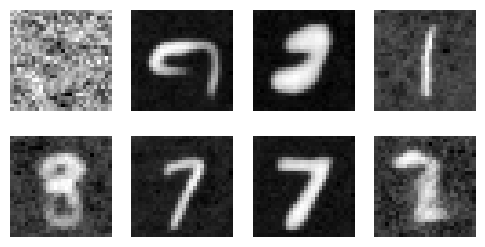

Epoch 6/20: 100%|██████████| 938/938 [00:47<00:00, 19.75it/s]


Epoch 6/20, Loss: 0.028418


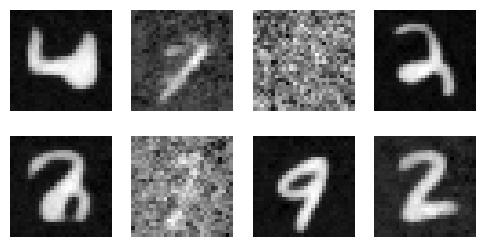

Epoch 7/20: 100%|██████████| 938/938 [00:47<00:00, 19.64it/s]


Epoch 7/20, Loss: 0.029177


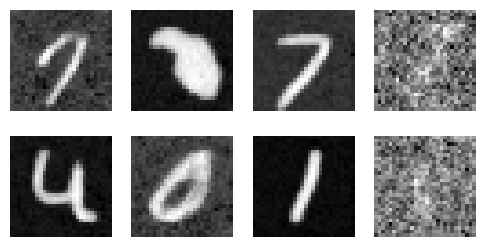

Epoch 8/20: 100%|██████████| 938/938 [00:47<00:00, 19.60it/s]


Epoch 8/20, Loss: 0.028089


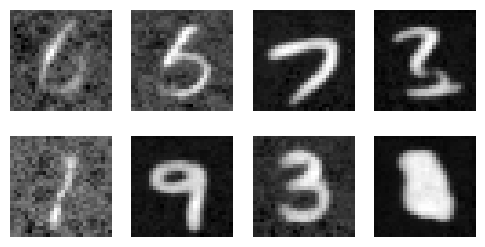

Epoch 9/20: 100%|██████████| 938/938 [00:47<00:00, 19.56it/s]


Epoch 9/20, Loss: 0.034373


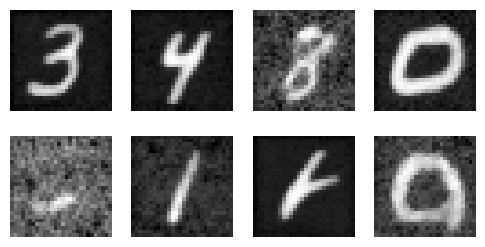

Epoch 10/20: 100%|██████████| 938/938 [00:47<00:00, 19.60it/s]


Epoch 10/20, Loss: 0.048518


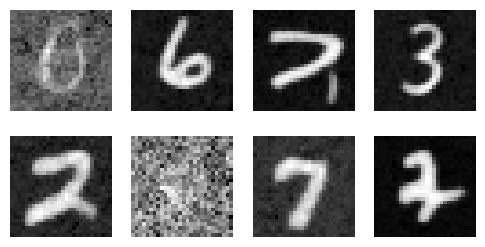

Epoch 11/20: 100%|██████████| 938/938 [00:48<00:00, 19.52it/s]


Epoch 11/20, Loss: 0.036591


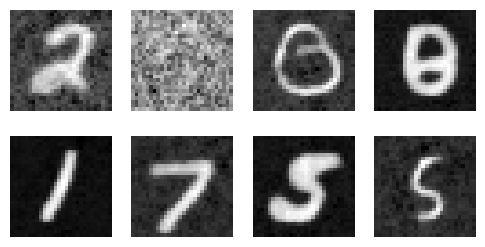

Epoch 12/20: 100%|██████████| 938/938 [00:48<00:00, 19.51it/s]


Epoch 12/20, Loss: 0.043816


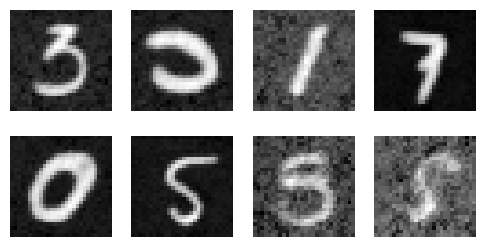

Epoch 13/20: 100%|██████████| 938/938 [00:48<00:00, 19.53it/s]


Epoch 13/20, Loss: 0.022534


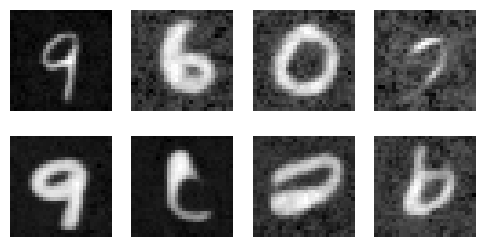

Epoch 14/20: 100%|██████████| 938/938 [00:48<00:00, 19.51it/s]


Epoch 14/20, Loss: 0.034048


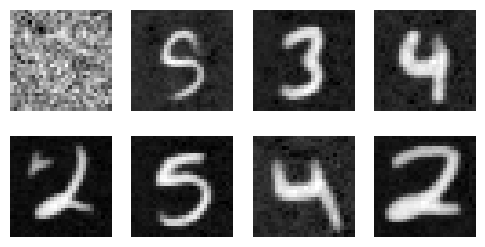

Epoch 15/20: 100%|██████████| 938/938 [00:47<00:00, 19.58it/s]


Epoch 15/20, Loss: 0.033999


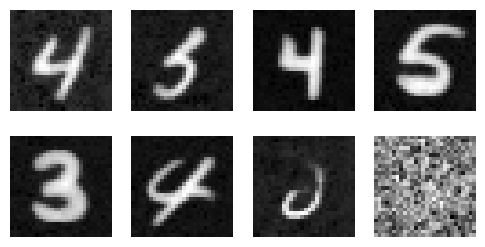

Epoch 16/20: 100%|██████████| 938/938 [00:48<00:00, 19.48it/s]


Epoch 16/20, Loss: 0.021818


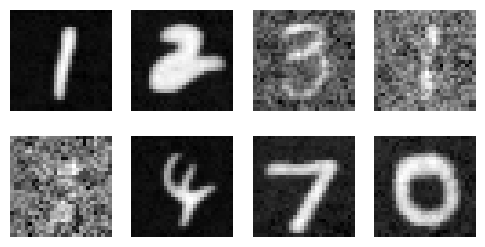

Epoch 17/20: 100%|██████████| 938/938 [00:48<00:00, 19.54it/s]


Epoch 17/20, Loss: 0.026823


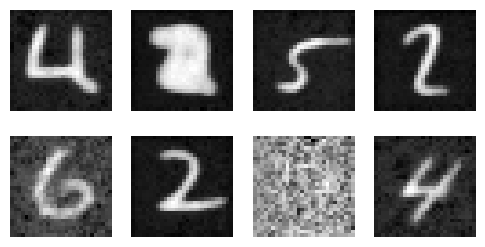

Epoch 18/20: 100%|██████████| 938/938 [00:48<00:00, 19.43it/s]


Epoch 18/20, Loss: 0.028275


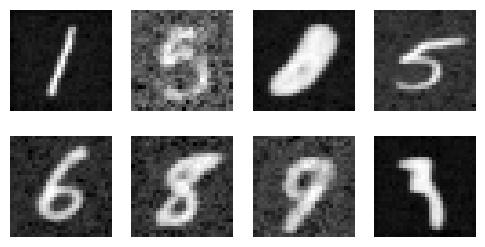

Epoch 19/20: 100%|██████████| 938/938 [00:48<00:00, 19.50it/s]


Epoch 19/20, Loss: 0.035043


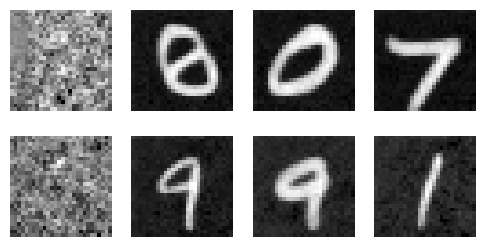

Epoch 20/20: 100%|██████████| 938/938 [00:47<00:00, 19.55it/s]


Epoch 20/20, Loss: 0.025347


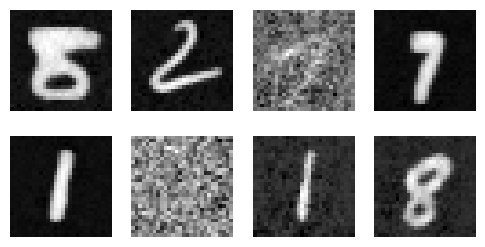

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def cosine_beta_schedule(timesteps):
    s = 0.008
    steps = torch.linspace(0, timesteps, timesteps + 1, dtype=torch.float32)
    alphas_cumprod = torch.cos(((steps / timesteps) + s) / (1 + s) * (np.pi / 2)) ** 2
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return betas.clamp(0.0001, 0.02)

# Define U-Net Model
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, time_emb_dim=128):
        super(UNet, self).__init__()
        
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, stride=1, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(),
                nn.Conv2d(out_c, out_c, 3, stride=1, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU()
            )
        
        self.time_embed = nn.Sequential(
            nn.Linear(1, time_emb_dim),
            nn.ReLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        # Encoder
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        # Decoder
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x, t):
        t = t.unsqueeze(-1).float() / 1000  # Assuming timesteps = 1000
        t_emb = self.time_embed(t).unsqueeze(-1).unsqueeze(-1)

        # Encoding
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # Decoding with skip connections
        u1 = F.interpolate(self.up1(e4), size=e3.shape[2:], mode='bilinear', align_corners=False)
        d1 = self.dec1(torch.cat([u1, e3], dim=1))

        u2 = F.interpolate(self.up2(d1), size=e2.shape[2:], mode='bilinear', align_corners=False)
        d2 = self.dec2(torch.cat([u2, e2], dim=1))

        u3 = F.interpolate(self.up3(d2), size=e1.shape[2:], mode='bilinear', align_corners=False)
        d3 = self.dec3(torch.cat([u3, e1], dim=1))

        return self.final(d3)

# DDPM Training and Sampling
class DDPM:
    def __init__(self, model, timesteps=1000, device='cpu'):
        self.model = model.to(device)
        self.timesteps = timesteps
        self.device = device
        self.beta = cosine_beta_schedule(timesteps).to(device)
        self.alpha = 1 - self.beta
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0).to(device)
    
    def forward_diffusion(self, x0, t):
        noise = torch.randn_like(x0)
        sqrt_alpha_cumprod_t = torch.sqrt(self.alpha_cumprod[t])[:, None, None, None]
        sqrt_one_minus_alpha_cumprod_t = torch.sqrt(1 - self.alpha_cumprod[t])[:, None, None, None]
        return sqrt_alpha_cumprod_t * x0 + sqrt_one_minus_alpha_cumprod_t * noise, noise
    
    def sample(self, shape):
        with torch.no_grad():
            x = torch.randn(shape, device=self.device)
            for t in reversed(range(self.timesteps)):
                t_tensor = torch.full((shape[0],), t, device=self.device).long()
                predicted_noise = self.model(x, t_tensor)

                alpha_t = self.alpha[t]
                alpha_cumprod_t = self.alpha_cumprod[t]
                sqrt_recip_alpha_t = 1 / torch.sqrt(alpha_t)
                sqrt_one_minus_alpha_cumprod_t = torch.sqrt(1 - alpha_cumprod_t)

                # Compute x_{t-1}
                x = sqrt_recip_alpha_t * (x - (1 - alpha_t) / sqrt_one_minus_alpha_cumprod_t * predicted_noise)

                # Add noise only if t > 0
                if t > 0:
                    z = torch.randn_like(x)
                    sigma_t = torch.sqrt(self.beta[t])
                    x += sigma_t * z

                torch.cuda.empty_cache()
            return x.cpu()

# Load MNIST Dataset
transform = transforms.Compose([transforms.ToTensor()])
dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Train the DDPM
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
ddpm = DDPM(model, device=device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

num_epochs = 20
for epoch in range(num_epochs):
    for x0, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True):
        x0 = x0.to(device)
        t = torch.randint(0, ddpm.timesteps, (x0.shape[0],), device=device).long()
        x_t, noise = ddpm.forward_diffusion(x0, t)
        predicted_noise = model(x_t, t)
        loss = F.mse_loss(predicted_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")

    # Generate Samples with Reduced Batch Size
    samples = ddpm.sample((8, 1, 28, 28))
    fig, axes = plt.subplots(2, 4, figsize=(6, 3))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i][0], cmap='gray')
        ax.axis('off')
    plt.show()

Epoch 1/50: 100%|██████████| 938/938 [00:18<00:00, 51.83it/s]


Epoch 1/50, Loss: 0.122092


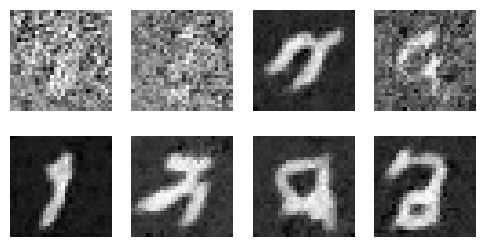

Epoch 2/50: 100%|██████████| 938/938 [00:18<00:00, 51.81it/s]


Epoch 2/50, Loss: 0.059554


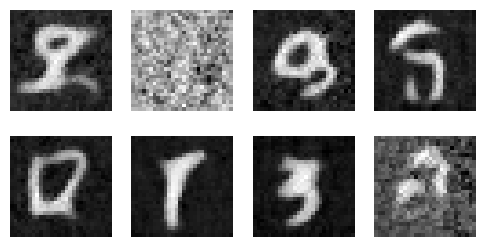

Epoch 3/50: 100%|██████████| 938/938 [00:18<00:00, 51.88it/s]


Epoch 3/50, Loss: 0.051724


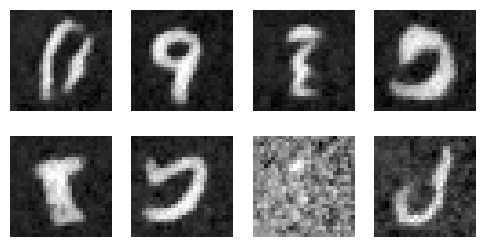

Epoch 4/50: 100%|██████████| 938/938 [00:18<00:00, 51.52it/s]


Epoch 4/50, Loss: 0.047851


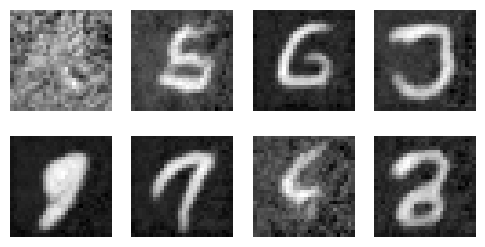

Epoch 5/50: 100%|██████████| 938/938 [00:18<00:00, 51.88it/s]


Epoch 5/50, Loss: 0.044787


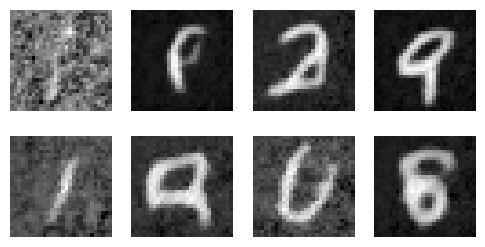

Epoch 6/50: 100%|██████████| 938/938 [00:18<00:00, 51.56it/s]


Epoch 6/50, Loss: 0.043057


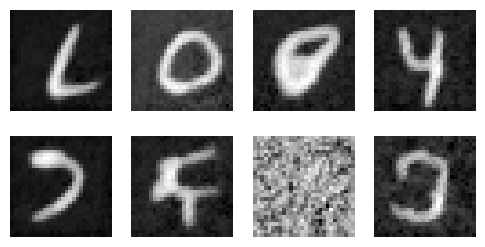

Epoch 7/50: 100%|██████████| 938/938 [00:18<00:00, 51.56it/s]


Epoch 7/50, Loss: 0.041363


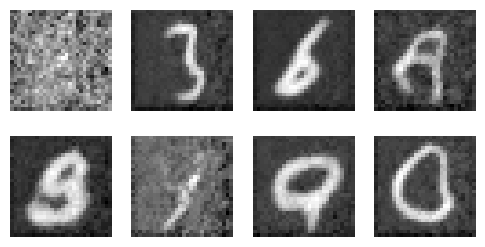

Epoch 8/50: 100%|██████████| 938/938 [00:18<00:00, 51.67it/s]


Epoch 8/50, Loss: 0.040419


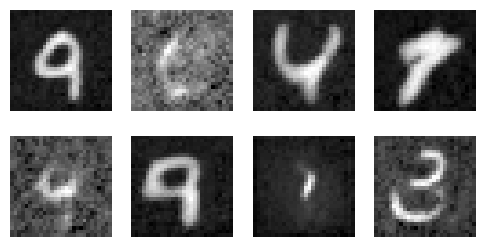

Epoch 9/50: 100%|██████████| 938/938 [00:18<00:00, 51.42it/s]


Epoch 9/50, Loss: 0.039238


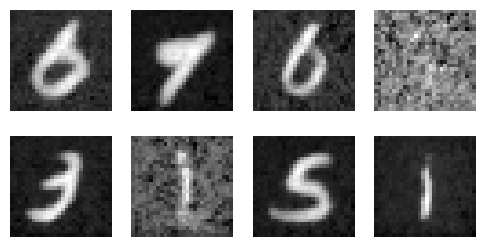

Epoch 10/50: 100%|██████████| 938/938 [00:18<00:00, 51.16it/s]


Epoch 10/50, Loss: 0.038472


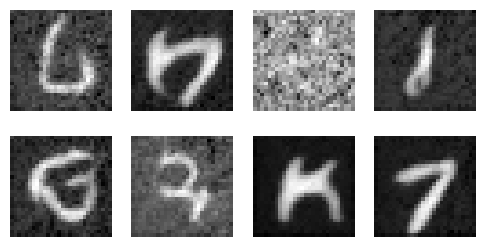

Epoch 11/50: 100%|██████████| 938/938 [00:18<00:00, 51.03it/s]


Epoch 11/50, Loss: 0.037894


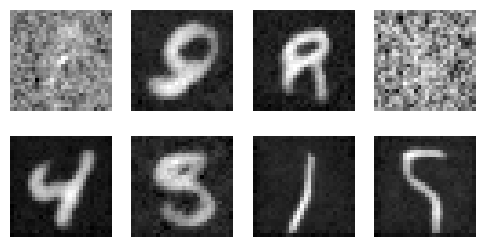

Epoch 12/50: 100%|██████████| 938/938 [00:18<00:00, 51.18it/s]


Epoch 12/50, Loss: 0.036861


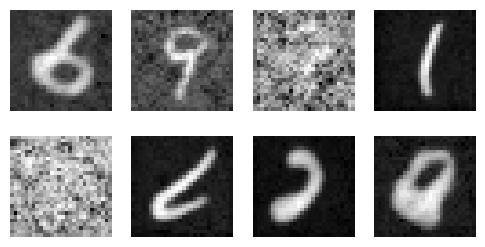

Epoch 13/50: 100%|██████████| 938/938 [00:18<00:00, 51.15it/s]


Epoch 13/50, Loss: 0.036695


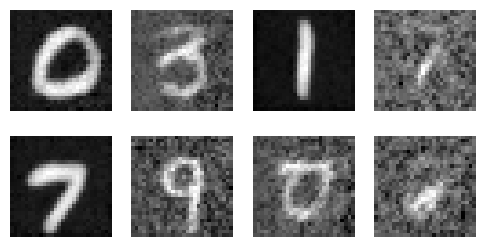

Epoch 14/50: 100%|██████████| 938/938 [00:18<00:00, 51.20it/s]


Epoch 14/50, Loss: 0.036418


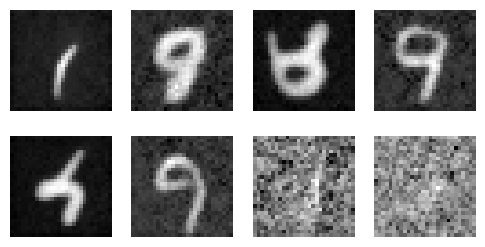

Epoch 15/50: 100%|██████████| 938/938 [00:18<00:00, 51.25it/s]


Epoch 15/50, Loss: 0.035773


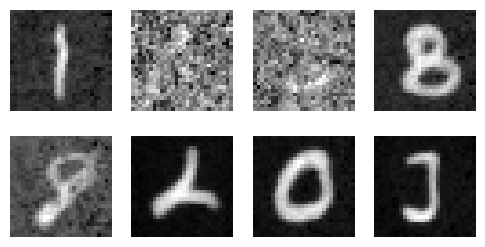

Epoch 16/50: 100%|██████████| 938/938 [00:18<00:00, 50.64it/s]


Epoch 16/50, Loss: 0.035667


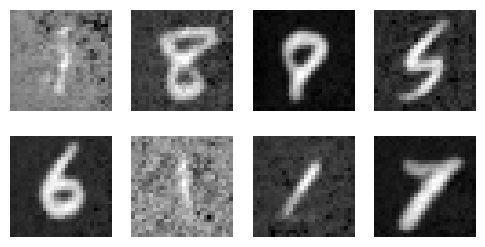

Epoch 17/50: 100%|██████████| 938/938 [00:18<00:00, 50.81it/s]


Epoch 17/50, Loss: 0.035258


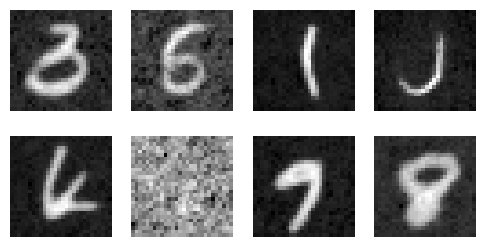

Epoch 18/50: 100%|██████████| 938/938 [00:18<00:00, 51.27it/s]


Epoch 18/50, Loss: 0.035132


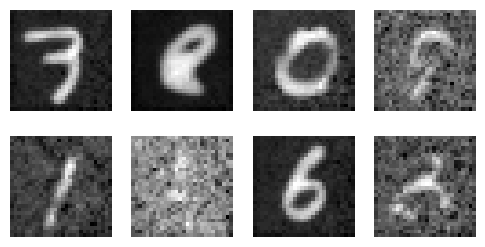

Epoch 19/50: 100%|██████████| 938/938 [00:18<00:00, 51.13it/s]


Epoch 19/50, Loss: 0.034670


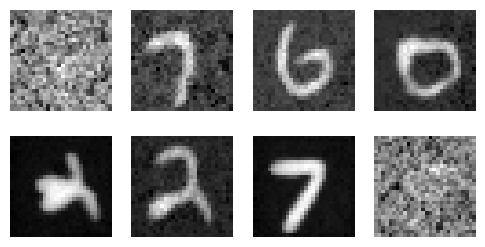

Epoch 20/50: 100%|██████████| 938/938 [00:18<00:00, 50.95it/s]


Epoch 20/50, Loss: 0.034628


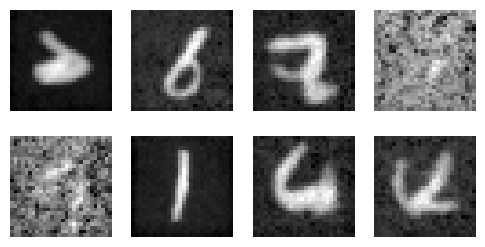

Epoch 21/50: 100%|██████████| 938/938 [00:18<00:00, 51.32it/s]


Epoch 21/50, Loss: 0.034324


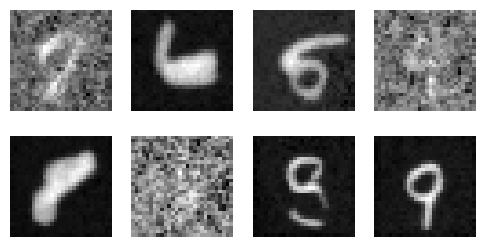

Epoch 22/50: 100%|██████████| 938/938 [00:18<00:00, 51.27it/s]


Epoch 22/50, Loss: 0.033941


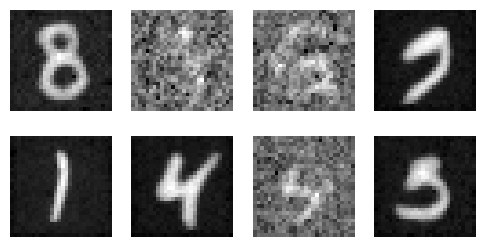

Epoch 23/50: 100%|██████████| 938/938 [00:18<00:00, 51.09it/s]


Epoch 23/50, Loss: 0.034206


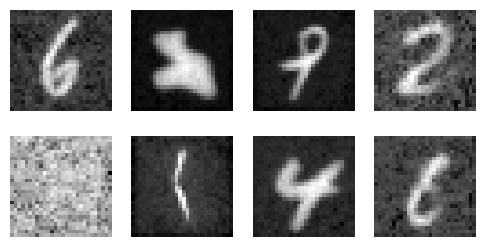

Epoch 24/50: 100%|██████████| 938/938 [00:18<00:00, 51.14it/s]


Epoch 24/50, Loss: 0.033911


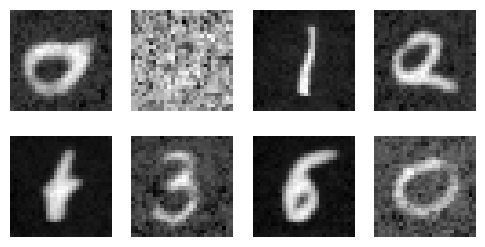

Epoch 25/50: 100%|██████████| 938/938 [00:18<00:00, 51.17it/s]


Epoch 25/50, Loss: 0.033212


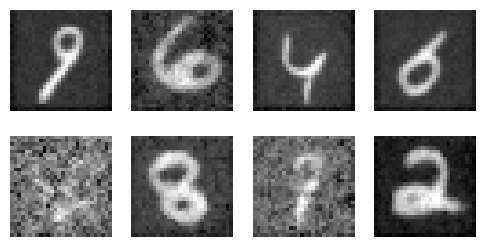

Epoch 26/50: 100%|██████████| 938/938 [00:18<00:00, 51.18it/s]


Epoch 26/50, Loss: 0.033426


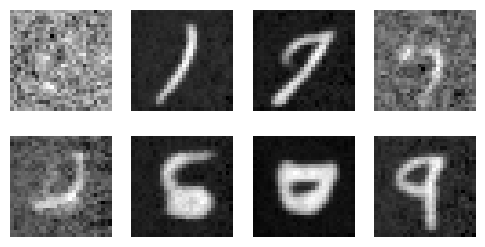

Epoch 27/50: 100%|██████████| 938/938 [00:18<00:00, 51.42it/s]


Epoch 27/50, Loss: 0.033104


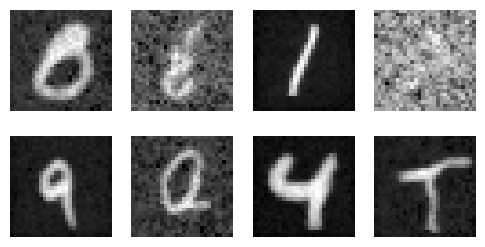

Epoch 28/50: 100%|██████████| 938/938 [00:18<00:00, 51.11it/s]


Epoch 28/50, Loss: 0.033174


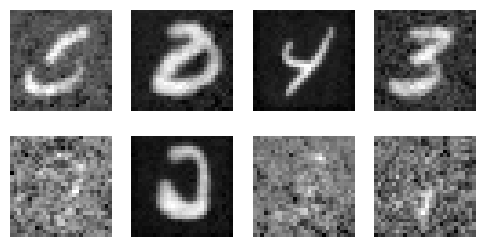

Epoch 29/50: 100%|██████████| 938/938 [00:18<00:00, 51.00it/s]


Epoch 29/50, Loss: 0.032699


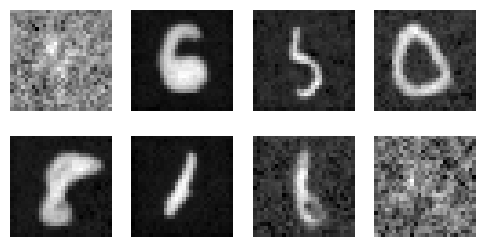

Epoch 30/50: 100%|██████████| 938/938 [00:18<00:00, 51.06it/s]


Epoch 30/50, Loss: 0.032793


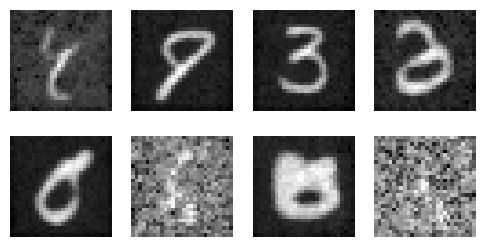

Epoch 31/50: 100%|██████████| 938/938 [00:18<00:00, 51.22it/s]


Epoch 31/50, Loss: 0.032630


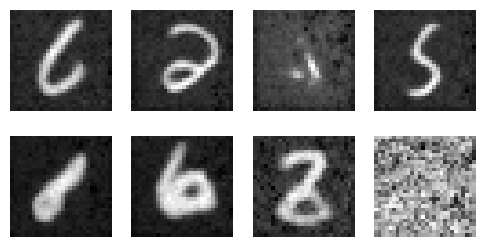

Epoch 32/50: 100%|██████████| 938/938 [00:18<00:00, 51.11it/s]


Epoch 32/50, Loss: 0.032401


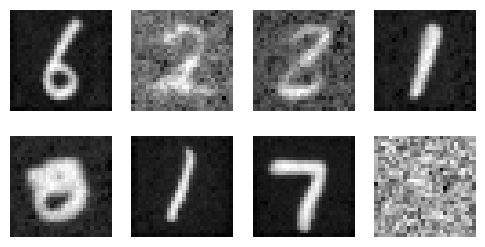

Epoch 33/50: 100%|██████████| 938/938 [00:18<00:00, 51.05it/s]


Epoch 33/50, Loss: 0.032577


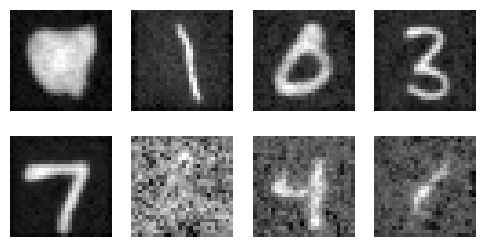

Epoch 34/50: 100%|██████████| 938/938 [00:18<00:00, 50.94it/s]


Epoch 34/50, Loss: 0.032268


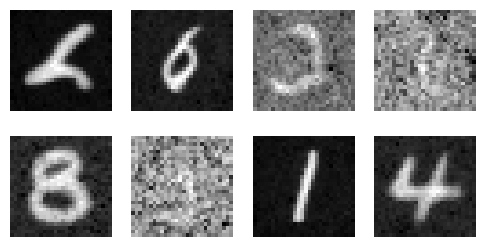

Epoch 35/50: 100%|██████████| 938/938 [00:18<00:00, 51.26it/s]


Epoch 35/50, Loss: 0.032280


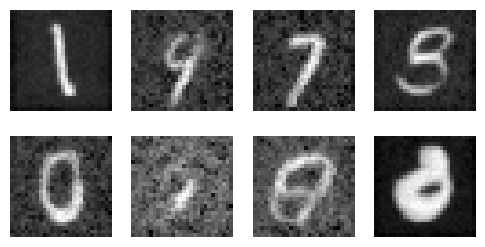

Epoch 36/50: 100%|██████████| 938/938 [00:18<00:00, 51.00it/s]


Epoch 36/50, Loss: 0.032333


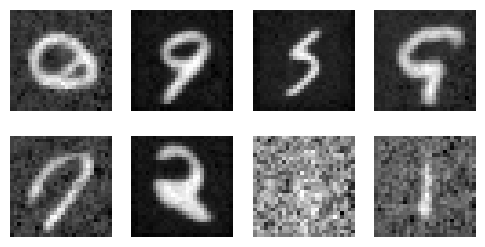

Epoch 37/50: 100%|██████████| 938/938 [00:18<00:00, 51.31it/s]


Epoch 37/50, Loss: 0.032030


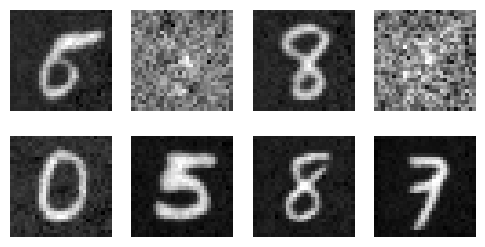

Epoch 38/50: 100%|██████████| 938/938 [00:18<00:00, 51.44it/s]


Epoch 38/50, Loss: 0.032003


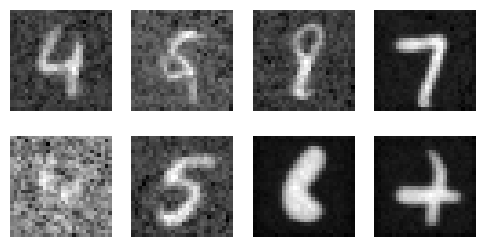

Epoch 39/50: 100%|██████████| 938/938 [00:18<00:00, 51.15it/s]


Epoch 39/50, Loss: 0.032055


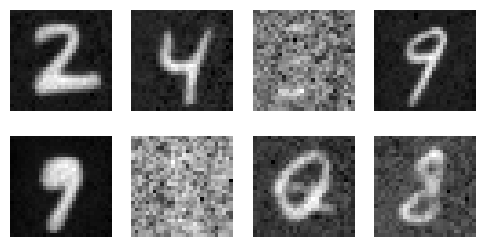

Epoch 40/50: 100%|██████████| 938/938 [00:18<00:00, 51.09it/s]


Epoch 40/50, Loss: 0.031982


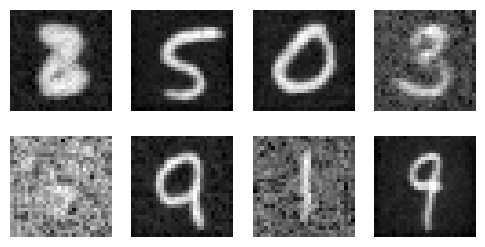

Epoch 41/50: 100%|██████████| 938/938 [00:18<00:00, 51.17it/s]


Epoch 41/50, Loss: 0.031895


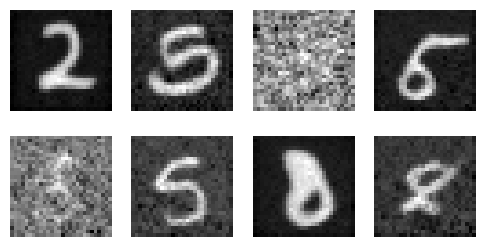

Epoch 42/50: 100%|██████████| 938/938 [00:18<00:00, 51.54it/s]


Epoch 42/50, Loss: 0.031786


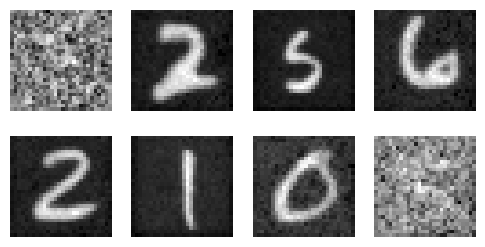

Epoch 43/50: 100%|██████████| 938/938 [00:18<00:00, 51.11it/s]


Epoch 43/50, Loss: 0.031319


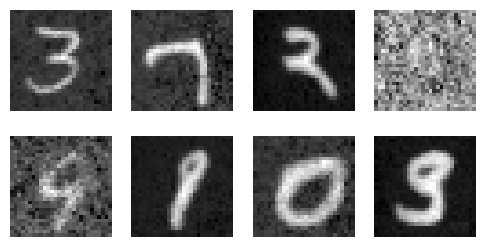

Epoch 44/50: 100%|██████████| 938/938 [00:18<00:00, 51.29it/s]


Epoch 44/50, Loss: 0.031537


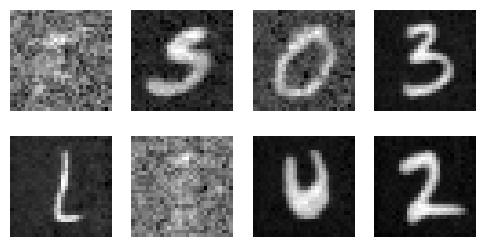

Epoch 45/50: 100%|██████████| 938/938 [00:18<00:00, 51.50it/s]


Epoch 45/50, Loss: 0.031433


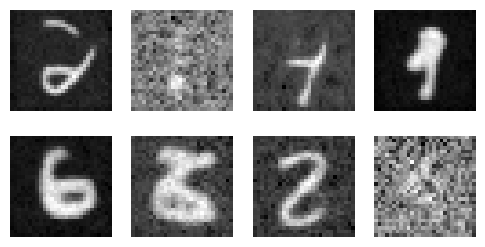

Epoch 46/50: 100%|██████████| 938/938 [00:18<00:00, 51.17it/s]


Epoch 46/50, Loss: 0.031505


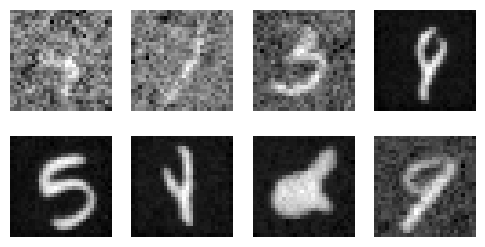

Epoch 47/50: 100%|██████████| 938/938 [00:18<00:00, 50.92it/s]


Epoch 47/50, Loss: 0.031527


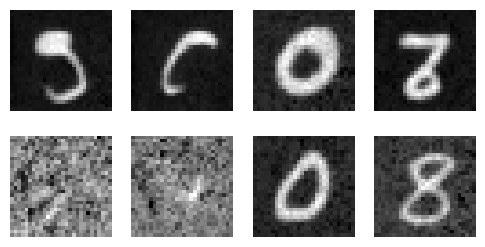

Epoch 48/50: 100%|██████████| 938/938 [00:18<00:00, 51.31it/s]


Epoch 48/50, Loss: 0.031357


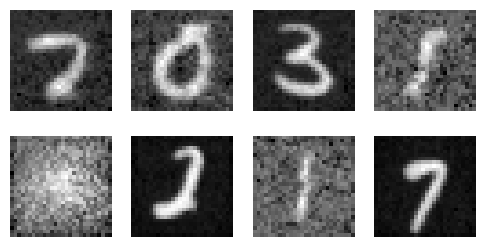

Epoch 49/50: 100%|██████████| 938/938 [00:18<00:00, 51.34it/s]


Epoch 49/50, Loss: 0.031012


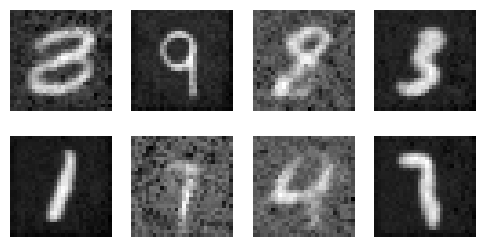

Epoch 50/50: 100%|██████████| 938/938 [00:18<00:00, 51.44it/s]


Epoch 50/50, Loss: 0.031184


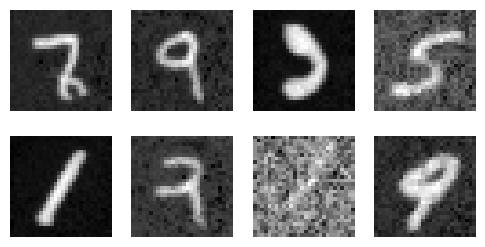

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def cosine_beta_schedule(timesteps):
    s = 0.008
    steps = torch.linspace(0, timesteps, timesteps + 1, dtype=torch.float32)
    alphas_cumprod = torch.cos(((steps / timesteps) + s) / (1 + s) * (np.pi / 2)) ** 2
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return betas.clamp(0.0001, 0.02)

# Define U-Net Model
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, time_emb_dim=128):
        super(UNet, self).__init__()
        
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, stride=1, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(),
                nn.Conv2d(out_c, out_c, 3, stride=1, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU()
            )
        
        self.time_embed = nn.Sequential(
            nn.Linear(1, time_emb_dim),
            nn.ReLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        # Encoder
        self.enc1 = conv_block(in_channels, 32)
        self.enc2 = conv_block(32, 64)
        self.enc3 = conv_block(64, 128)
        
        # Decoder
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec2 = conv_block(64, 32)

        self.final = nn.Conv2d(32, out_channels, kernel_size=1)
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x, t):
        t_emb = self.time_embed(t.float().unsqueeze(-1))  # Ensure t has correct shape
        # t_emb = t_emb.unsqueeze(-1).unsqueeze(-1)  # Expand for broadcasting

        # Encoding
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        # Decoding with skip connections
        u1 = F.interpolate(self.up1(e3), size=e2.shape[2:], mode='bilinear', align_corners=False)
        d1 = self.dec1(torch.cat([u1, e2], dim=1))

        u2 = F.interpolate(self.up2(d1), size=e1.shape[2:], mode='bilinear', align_corners=False)
        d2 = self.dec2(torch.cat([u2, e1], dim=1))

        return self.final(d2)

# DDPM Training and Sampling
class DDPM:
    def __init__(self, model, timesteps=1000, device='cpu'):
        self.model = model.to(device)
        self.timesteps = timesteps
        self.device = device
        self.beta = cosine_beta_schedule(timesteps).to(device)
        self.alpha = 1 - self.beta
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0).to(device)
    
    def forward_diffusion(self, x0, t):
        noise = torch.randn_like(x0)
        sqrt_alpha_cumprod_t = torch.sqrt(self.alpha_cumprod[t])[:, None, None, None]
        sqrt_one_minus_alpha_cumprod_t = torch.sqrt(1 - self.alpha_cumprod[t])[:, None, None, None]
        return sqrt_alpha_cumprod_t * x0 + sqrt_one_minus_alpha_cumprod_t * noise, noise
    
    def sample(self, shape):
        with torch.no_grad():
            x = torch.randn(shape, device=self.device)
            for t in reversed(range(self.timesteps)):
                t_tensor = torch.full((shape[0],), t, device=self.device).long()
                predicted_noise = self.model(x, t_tensor)
                alpha_t = self.alpha[t]
                alpha_cumprod_t = self.alpha_cumprod[t]
                sqrt_recip_alpha_t = 1 / torch.sqrt(alpha_t)
                sqrt_one_minus_alpha_cumprod_t = torch.sqrt(1 - alpha_cumprod_t)
                x = sqrt_recip_alpha_t * (x - (1 - alpha_t) / sqrt_one_minus_alpha_cumprod_t * predicted_noise)
                if t > 0:
                    z = torch.randn_like(x)
                    sigma_t = torch.sqrt(self.beta[t])
                    x += sigma_t * z
                torch.cuda.empty_cache()
            return x.cpu()

# Load MNIST Dataset
transform = transforms.Compose([transforms.ToTensor()])
dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Train the DDPM
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
ddpm = DDPM(model, device=device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
loss_fn = nn.MSELoss()

num_epochs = 50
for epoch in range(num_epochs):
    epoch_loss = 0
    for x0, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True):
        x0 = x0.to(device)
        t = torch.randint(0, ddpm.timesteps, (x0.shape[0],), device=device).long()
        x_t, noise = ddpm.forward_diffusion(x0, t)
        predicted_noise = model(x_t, t)
        loss = loss_fn(predicted_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(dataloader):.6f}")

# Generate Samples
    samples = ddpm.sample((8, 1, 28, 28))
    fig, axes = plt.subplots(2, 4, figsize=(6, 3))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i][0], cmap='gray')
        ax.axis('off')
    plt.show()

Epoch 1/50: 100%|██████████| 938/938 [00:18<00:00, 51.68it/s]


Epoch 1/50, Loss: 0.055949


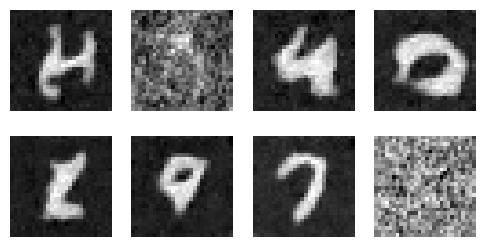

Epoch 2/50: 100%|██████████| 938/938 [00:18<00:00, 51.41it/s]


Epoch 2/50, Loss: 0.028530


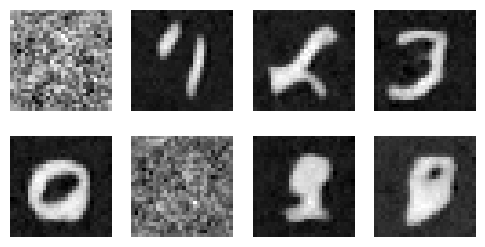

Epoch 3/50: 100%|██████████| 938/938 [00:18<00:00, 51.78it/s]


Epoch 3/50, Loss: 0.024565


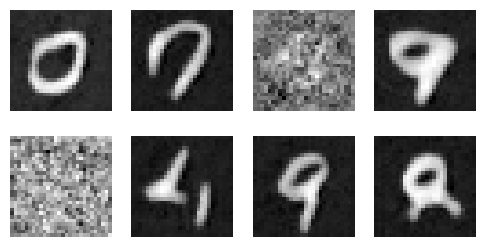

Epoch 4/50: 100%|██████████| 938/938 [00:18<00:00, 51.50it/s]


Epoch 4/50, Loss: 0.022612


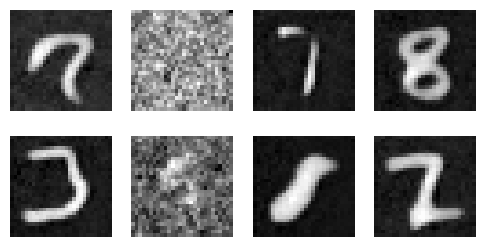

Epoch 5/50: 100%|██████████| 938/938 [00:18<00:00, 51.41it/s]


Epoch 5/50, Loss: 0.021210


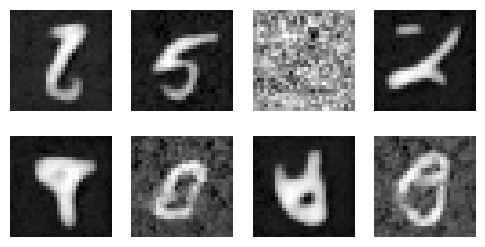

Epoch 6/50: 100%|██████████| 938/938 [00:18<00:00, 51.58it/s]


Epoch 6/50, Loss: 0.020193


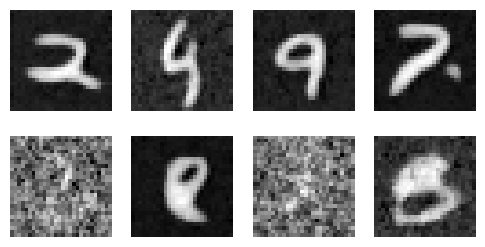

Epoch 7/50: 100%|██████████| 938/938 [00:18<00:00, 51.42it/s]


Epoch 7/50, Loss: 0.019440


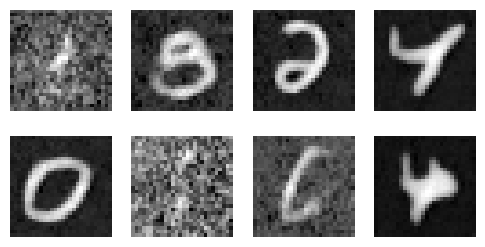

Epoch 8/50: 100%|██████████| 938/938 [00:18<00:00, 51.40it/s]


Epoch 8/50, Loss: 0.018856


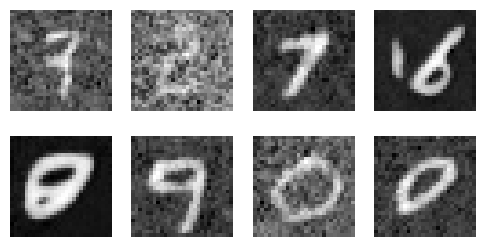

Epoch 9/50: 100%|██████████| 938/938 [00:18<00:00, 51.59it/s]


Epoch 9/50, Loss: 0.018429


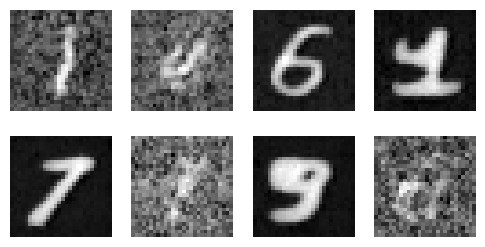

Epoch 10/50: 100%|██████████| 938/938 [00:18<00:00, 51.29it/s]


Epoch 10/50, Loss: 0.018186


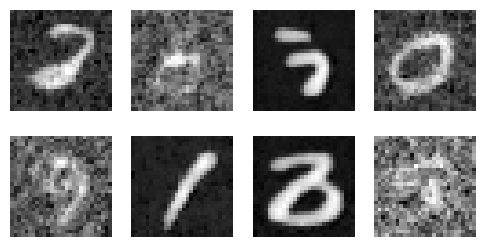

Epoch 11/50: 100%|██████████| 938/938 [00:18<00:00, 51.13it/s]


Epoch 11/50, Loss: 0.017757


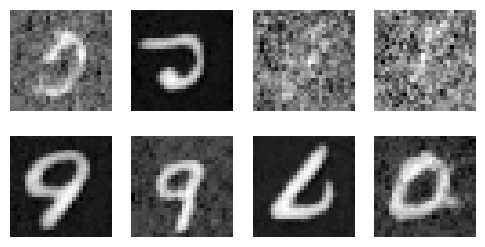

Epoch 12/50: 100%|██████████| 938/938 [00:18<00:00, 51.18it/s]


Epoch 12/50, Loss: 0.017649


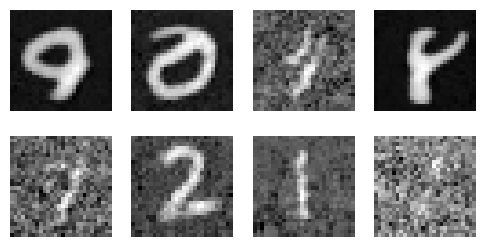

Epoch 13/50: 100%|██████████| 938/938 [00:18<00:00, 51.26it/s]


Epoch 13/50, Loss: 0.017299


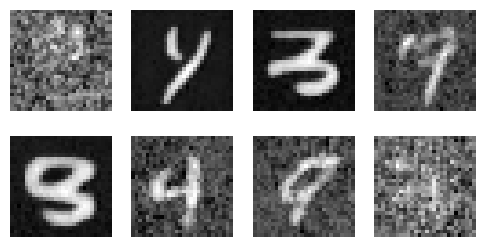

Epoch 14/50: 100%|██████████| 938/938 [00:18<00:00, 51.18it/s]


Epoch 14/50, Loss: 0.017317


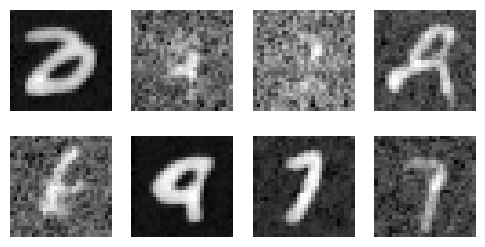

Epoch 15/50: 100%|██████████| 938/938 [00:18<00:00, 51.31it/s]


Epoch 15/50, Loss: 0.016965


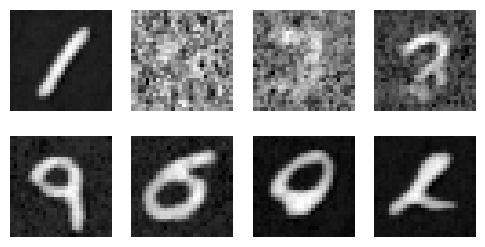

Epoch 16/50: 100%|██████████| 938/938 [00:18<00:00, 51.20it/s]


Epoch 16/50, Loss: 0.016804


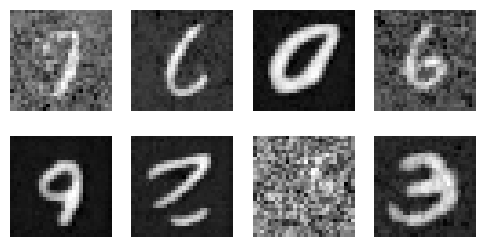

Epoch 17/50: 100%|██████████| 938/938 [00:18<00:00, 51.19it/s]


Epoch 17/50, Loss: 0.016665


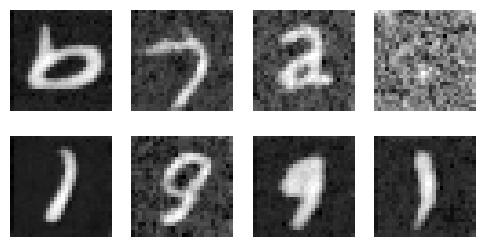

Epoch 18/50: 100%|██████████| 938/938 [00:18<00:00, 51.33it/s]


Epoch 18/50, Loss: 0.016457


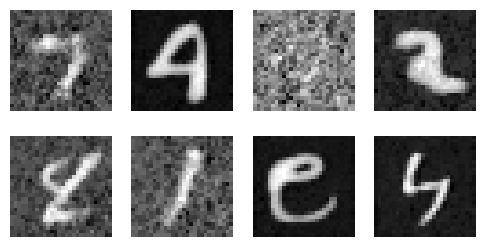

Epoch 19/50: 100%|██████████| 938/938 [00:18<00:00, 51.36it/s]


Epoch 19/50, Loss: 0.016342


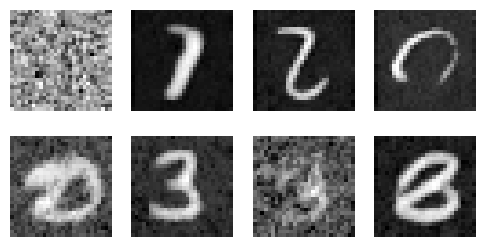

Epoch 20/50: 100%|██████████| 938/938 [00:18<00:00, 51.15it/s]


Epoch 20/50, Loss: 0.016175


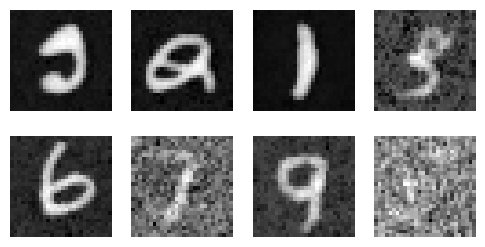

Epoch 21/50: 100%|██████████| 938/938 [00:18<00:00, 51.19it/s]


Epoch 21/50, Loss: 0.016183


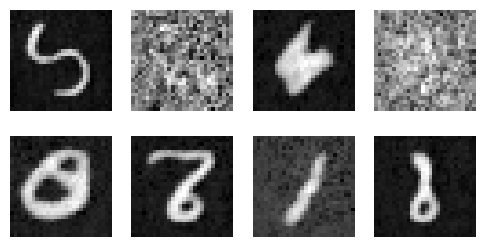

Epoch 22/50: 100%|██████████| 938/938 [00:18<00:00, 51.29it/s]


Epoch 22/50, Loss: 0.016157


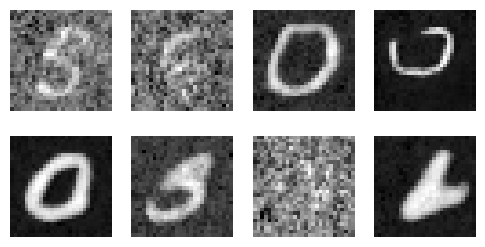

Epoch 23/50: 100%|██████████| 938/938 [00:18<00:00, 51.15it/s]


Epoch 23/50, Loss: 0.015914


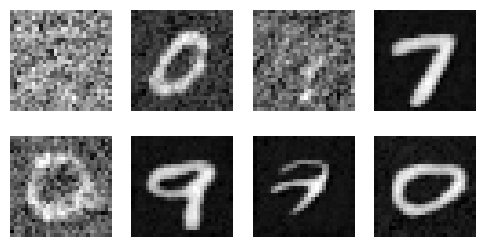

Epoch 24/50: 100%|██████████| 938/938 [00:18<00:00, 51.00it/s]


Epoch 24/50, Loss: 0.015950


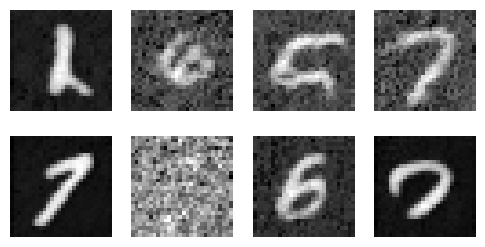

Epoch 25/50: 100%|██████████| 938/938 [00:18<00:00, 51.00it/s]


Epoch 25/50, Loss: 0.015765


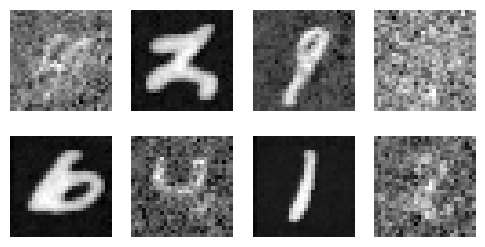

Epoch 26/50: 100%|██████████| 938/938 [00:18<00:00, 51.15it/s]


Epoch 26/50, Loss: 0.015756


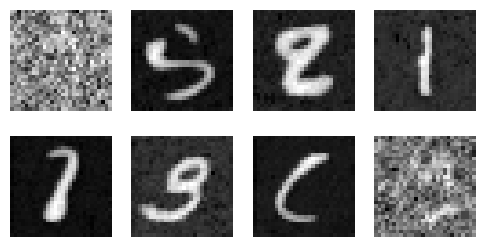

Epoch 27/50: 100%|██████████| 938/938 [00:18<00:00, 51.42it/s]


Epoch 27/50, Loss: 0.015779


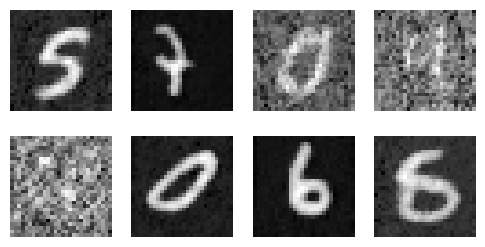

Epoch 28/50: 100%|██████████| 938/938 [00:18<00:00, 51.14it/s]


Epoch 28/50, Loss: 0.015530


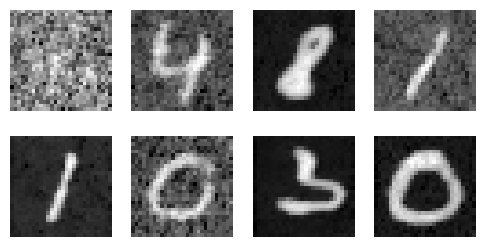

Epoch 29/50: 100%|██████████| 938/938 [00:18<00:00, 51.39it/s]


Epoch 29/50, Loss: 0.015679


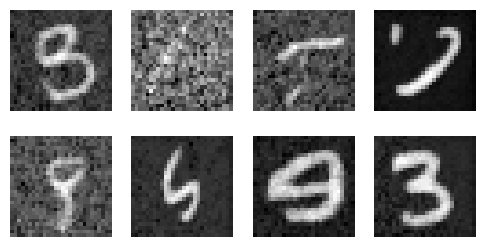

Epoch 30/50: 100%|██████████| 938/938 [00:18<00:00, 51.64it/s]


Epoch 30/50, Loss: 0.015528


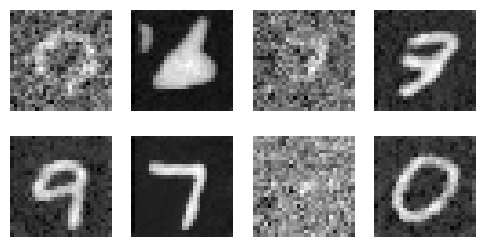

Epoch 31/50: 100%|██████████| 938/938 [00:18<00:00, 51.12it/s]


Epoch 31/50, Loss: 0.015303


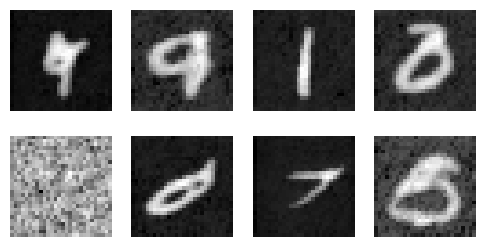

Epoch 32/50: 100%|██████████| 938/938 [00:18<00:00, 51.48it/s]


Epoch 32/50, Loss: 0.015493


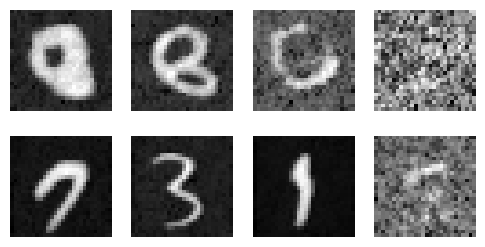

Epoch 33/50: 100%|██████████| 938/938 [00:18<00:00, 51.62it/s]


Epoch 33/50, Loss: 0.015273


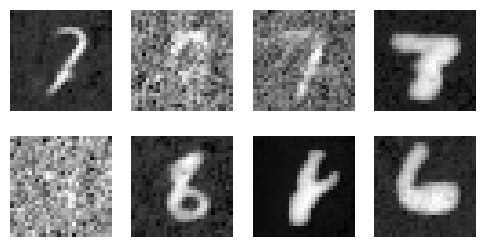

Epoch 34/50: 100%|██████████| 938/938 [00:18<00:00, 51.51it/s]


Epoch 34/50, Loss: 0.015312


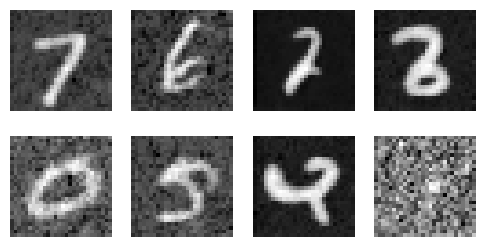

Epoch 35/50: 100%|██████████| 938/938 [00:18<00:00, 51.20it/s]


Epoch 35/50, Loss: 0.015342


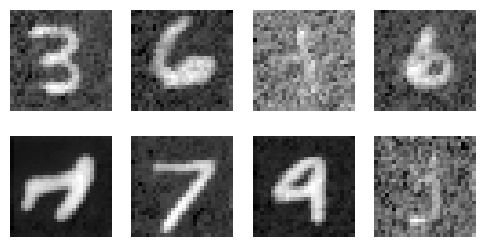

Epoch 36/50: 100%|██████████| 938/938 [00:18<00:00, 51.35it/s]


Epoch 36/50, Loss: 0.015232


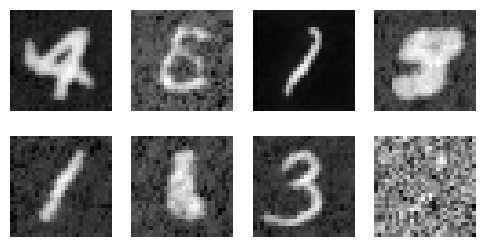

Epoch 37/50: 100%|██████████| 938/938 [00:18<00:00, 51.19it/s]


Epoch 37/50, Loss: 0.015164


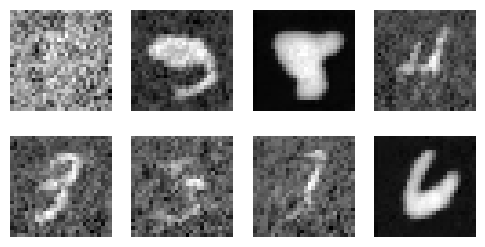

Epoch 38/50: 100%|██████████| 938/938 [00:18<00:00, 51.18it/s]


Epoch 38/50, Loss: 0.015166


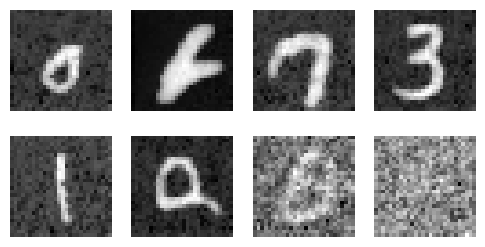

Epoch 39/50: 100%|██████████| 938/938 [00:18<00:00, 51.14it/s]


Epoch 39/50, Loss: 0.015007


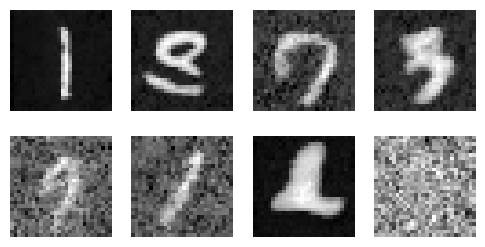

Epoch 40/50: 100%|██████████| 938/938 [00:18<00:00, 51.58it/s]


Epoch 40/50, Loss: 0.015162


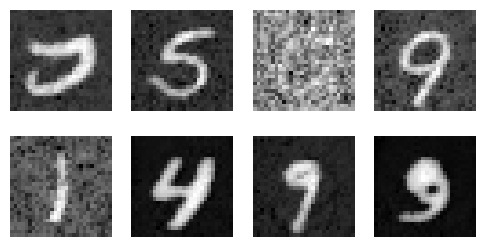

Epoch 41/50: 100%|██████████| 938/938 [00:18<00:00, 51.53it/s]


Epoch 41/50, Loss: 0.015091


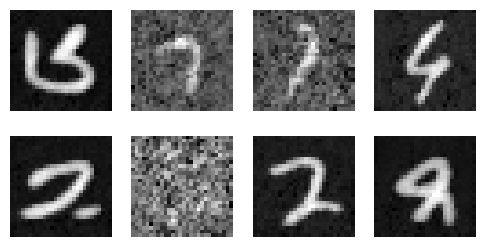

Epoch 42/50: 100%|██████████| 938/938 [00:18<00:00, 51.62it/s]


Epoch 42/50, Loss: 0.015035


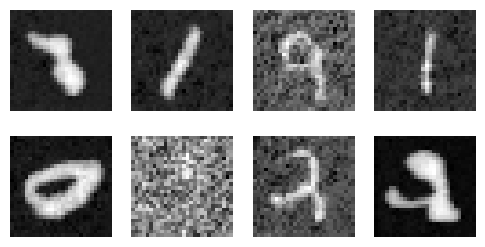

Epoch 43/50: 100%|██████████| 938/938 [00:18<00:00, 51.30it/s]


Epoch 43/50, Loss: 0.014922


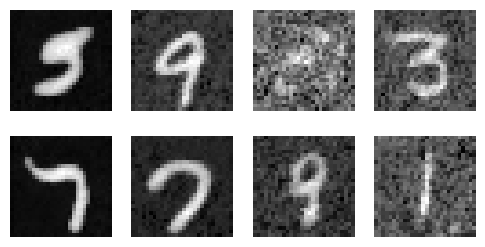

Epoch 44/50: 100%|██████████| 938/938 [00:18<00:00, 51.56it/s]


Epoch 44/50, Loss: 0.014873


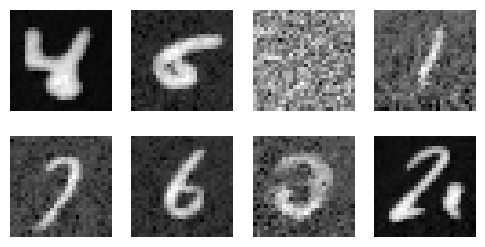

Epoch 45/50: 100%|██████████| 938/938 [00:18<00:00, 51.42it/s]


Epoch 45/50, Loss: 0.014912


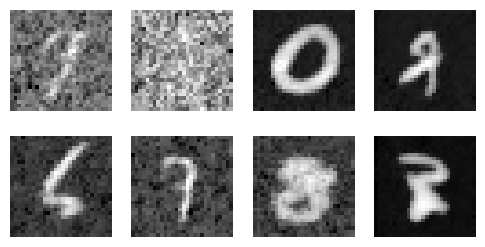

Epoch 46/50: 100%|██████████| 938/938 [00:18<00:00, 51.37it/s]


Epoch 46/50, Loss: 0.014897


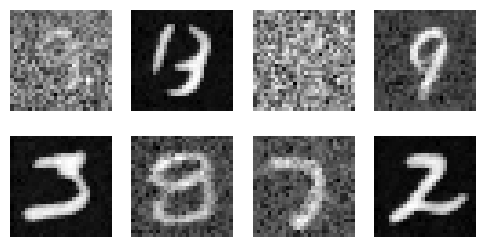

Epoch 47/50: 100%|██████████| 938/938 [00:18<00:00, 51.19it/s]


Epoch 47/50, Loss: 0.014814


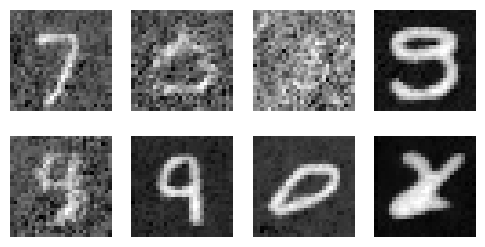

Epoch 48/50: 100%|██████████| 938/938 [00:18<00:00, 51.43it/s]


Epoch 48/50, Loss: 0.014896


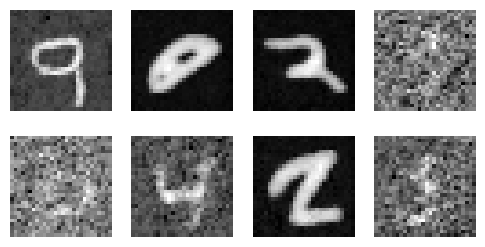

Epoch 49/50: 100%|██████████| 938/938 [00:18<00:00, 51.09it/s]


Epoch 49/50, Loss: 0.014870


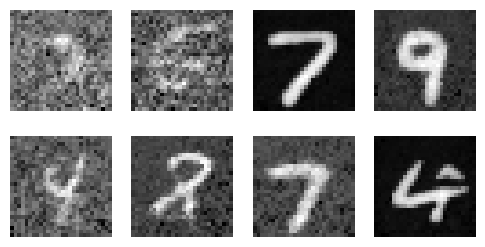

Epoch 50/50: 100%|██████████| 938/938 [00:18<00:00, 51.26it/s]


Epoch 50/50, Loss: 0.014730


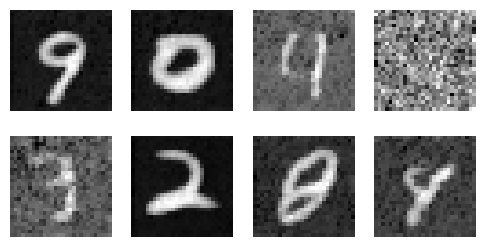

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def cosine_beta_schedule(timesteps):
    s = 0.008
    steps = torch.linspace(0, timesteps, timesteps + 1, dtype=torch.float32)
    alphas_cumprod = torch.cos(((steps / timesteps) + s) / (1 + s) * (np.pi / 2)) ** 2
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return betas.clamp(0.0001, 0.02)

# Define U-Net Model
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, time_emb_dim=128):
        super(UNet, self).__init__()
        
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, stride=1, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(),
                nn.Conv2d(out_c, out_c, 3, stride=1, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU()
            )
        
        self.time_embed = nn.Sequential(
            nn.Linear(1, time_emb_dim),
            nn.ReLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        # Encoder
        self.enc1 = conv_block(in_channels, 32)
        self.enc2 = conv_block(32, 64)
        self.enc3 = conv_block(64, 128)
        
        # Decoder
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec2 = conv_block(64, 32)

        self.final = nn.Conv2d(32, out_channels, kernel_size=1)
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x, t):
        t_emb = self.time_embed(t.float().unsqueeze(-1))  # Ensure t has correct shape
        # t_emb = t_emb.unsqueeze(-1).unsqueeze(-1)  # Expand for broadcasting

        # Encoding
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        # Decoding with skip connections
        u1 = F.interpolate(self.up1(e3), size=e2.shape[2:], mode='bilinear', align_corners=False)
        d1 = self.dec1(torch.cat([u1, e2], dim=1))

        u2 = F.interpolate(self.up2(d1), size=e1.shape[2:], mode='bilinear', align_corners=False)
        d2 = self.dec2(torch.cat([u2, e1], dim=1))

        return self.final(d2)

# DDPM Training and Sampling
class DDPM:
    def __init__(self, model, timesteps=1000, device='cpu'):
        self.model = model.to(device)
        self.timesteps = timesteps
        self.device = device
        self.beta = cosine_beta_schedule(timesteps).to(device)
        self.alpha = 1 - self.beta
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0).to(device)
    
    def forward_diffusion(self, x0, t):
        noise = torch.randn_like(x0)
        sqrt_alpha_cumprod_t = torch.sqrt(self.alpha_cumprod[t])[:, None, None, None]
        sqrt_one_minus_alpha_cumprod_t = torch.sqrt(1 - self.alpha_cumprod[t])[:, None, None, None]
        return sqrt_alpha_cumprod_t * x0 + sqrt_one_minus_alpha_cumprod_t * noise, noise
    
    def sample(self, shape):
        with torch.no_grad():
            x = torch.randn(shape, device=self.device)
            for t in reversed(range(self.timesteps)):
                t_tensor = torch.full((shape[0],), t, device=self.device).long()
                predicted_noise = self.model(x, t_tensor)
                alpha_t = self.alpha[t]
                alpha_cumprod_t = self.alpha_cumprod[t]
                sqrt_recip_alpha_t = 1 / torch.sqrt(alpha_t)
                sqrt_one_minus_alpha_cumprod_t = torch.sqrt(1 - alpha_cumprod_t)
                x = sqrt_recip_alpha_t * (x - (1 - alpha_t) / sqrt_one_minus_alpha_cumprod_t * predicted_noise)
                if t > 0:
                    z = torch.randn_like(x)
                    sigma_t = torch.sqrt(self.beta[t])
                    x += sigma_t * z
                torch.cuda.empty_cache()
            return x.cpu()

# Load MNIST Dataset
transform = transforms.Compose([transforms.ToTensor()])
dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Train the DDPM
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
ddpm = DDPM(model, device=device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
loss_fn = nn.HuberLoss()

num_epochs = 50
for epoch in range(num_epochs):
    epoch_loss = 0
    for x0, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True):
        x0 = x0.to(device)
        t = torch.randint(0, ddpm.timesteps, (x0.shape[0],), device=device).long()
        x_t, noise = ddpm.forward_diffusion(x0, t)
        predicted_noise = model(x_t, t)
        loss = loss_fn(predicted_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(dataloader):.6f}")

# Generate Samples
    samples = ddpm.sample((8, 1, 28, 28))
    fig, axes = plt.subplots(2, 4, figsize=(6, 3))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i][0], cmap='gray')
        ax.axis('off')
    plt.show()